In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname = 'flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)



In [2]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


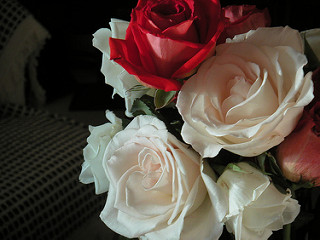

In [3]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


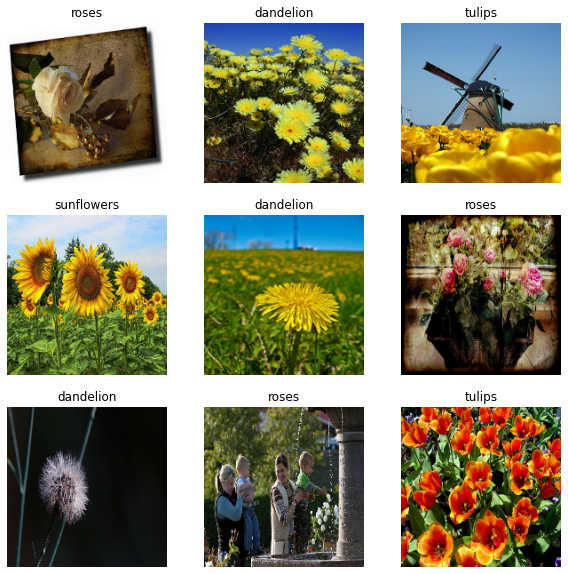

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation= 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 18s 32ms/step - loss: 1.3048 - accuracy: 0.4401 - val_loss: 1.1690 - val_accuracy: 0.5041
Epoch 2/3
92/92 [==============================] - 2s 20ms/step - loss: 1.0650 - accuracy: 0.5746 - val_loss: 1.0041 - val_accuracy: 0.6022
Epoch 3/3
92/92 [==============================] - 2s 20ms/step - loss: 0.9174 - accuracy: 0.6465 - val_loss: 0.9185 - val_accuracy: 0.6417


In [16]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle = False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [17]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\Sk4re\\.keras\\datasets\\flower_photos\\roses\\4495885281_fe2a3b671d.jpg'
b'C:\\Users\\Sk4re\\.keras\\datasets\\flower_photos\\tulips\\3626132563_d955973447_n.jpg'
b'C:\\Users\\Sk4re\\.keras\\datasets\\flower_photos\\dandelion\\17220096449_0e535989f0_n.jpg'
b'C:\\Users\\Sk4re\\.keras\\datasets\\flower_photos\\sunflowers\\6198569425_e953b9e6cc_m.jpg'
b'C:\\Users\\Sk4re\\.keras\\datasets\\flower_photos\\roses\\269037241_07fceff56a_m.jpg'


In [18]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [19]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [20]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [21]:
def get_label(file_path):
    # conver the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # the second to last is the class-directory
    one_hot = parts[-2] == class_names
    # integer encode the label
    return tf.argmax(one_hot)

In [22]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [23]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [24]:
# Set 'num_parallel_calls' so multiple images are loaded/processed in parallel
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [25]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [26]:
# To train a model with this dataset you will want the data:
# 
# To be well shuffled.
# To be batched.
# Batches to be available as soon as possible.

In [27]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

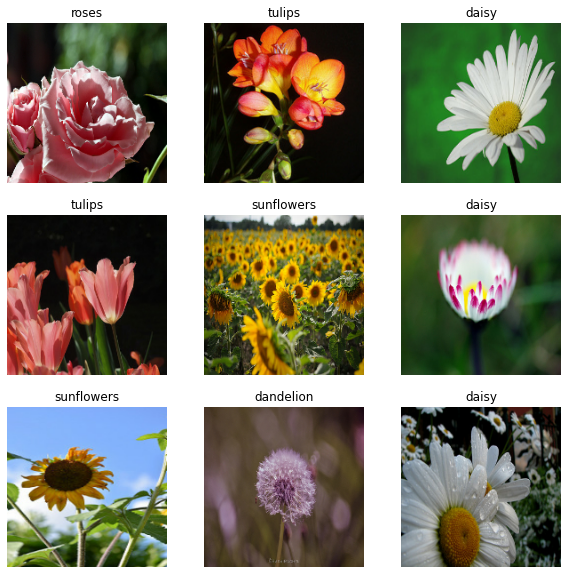

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [64]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 8
)

Epoch 1/8
92/92 [==============================] - 2s 21ms/step - loss: 0.2190 - accuracy: 0.9268 - val_loss: 0.8677 - val_accuracy: 0.7207
Epoch 2/8
92/92 [==============================] - 2s 22ms/step - loss: 0.1236 - accuracy: 0.9649 - val_loss: 0.9856 - val_accuracy: 0.7248
Epoch 3/8
92/92 [==============================] - 2s 23ms/step - loss: 0.0782 - accuracy: 0.9782 - val_loss: 1.1271 - val_accuracy: 0.7112
Epoch 4/8
92/92 [==============================] - 2s 22ms/step - loss: 0.0780 - accuracy: 0.9772 - val_loss: 1.4392 - val_accuracy: 0.6894
Epoch 5/8
92/92 [==============================] - 2s 23ms/step - loss: 0.0808 - accuracy: 0.9772 - val_loss: 1.3012 - val_accuracy: 0.7207
Epoch 6/8
92/92 [==============================] - 2s 21ms/step - loss: 0.0241 - accuracy: 0.9932 - val_loss: 1.4591 - val_accuracy: 0.7071
Epoch 7/8
92/92 [==============================] - 2s 21ms/step - loss: 0.0412 - accuracy: 0.9877 - val_loss: 1.4882 - val_accuracy: 0.7044
Epoch 8/8
92/92 [===

In [67]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 100%|██████████| 1/1 [03:53<00:00, 233.89s/ url]
                                                                        

Dataset tf_flowers downloaded and prepared to C:\Users\Sk4re\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


AssertionError: Unrecognized instruction format: train[80%:90%

In [68]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

NameError: name 'metadata' is not defined

In [69]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

NameError: name 'metadata' is not defined

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)